## 投票法的思路

&emsp;&emsp;投票法是集成学习中常用的技巧，可以帮助我们提高模型的泛化能力，减少模型的错误率。举个例子，在航空航天领域，每个零件发出的电信号都对航空器的成功发射起到重要作用。如果我们有一个二进制形式的信号：

11101100100111001011011011011

在传输过程中第二位发生了翻转

10101100100111001011011011011

&emsp;&emsp;这导致的结果可能是致命的。一个常用的纠错方法是重复多次发送数据，并以少数服从多数的方法确定正确的传输数据。一般情况下，错误总是发生在局部，因此融合多个数据是降低误差的一个好方法，这就是投票法的基本思路。

&emsp;&emsp;对于回归模型来说，投票法最终的预测结果是多个其他回归模型预测结果的平均值。

&emsp;&emsp;对于分类模型，硬投票法的预测结果是多个模型预测结果中出现次数最多的类别，软投票对各类预测结果的概率进行求和，最终选取概率之和最大的类标签。


## 投票法的原理分析

&emsp;&emsp;投票法是一种遵循少数服从多数原则的集成学习模型，通过多个模型的集成降低方差，从而提高模型的鲁棒性。在理想情况下，投票法的预测效果应当优于任何一个基模型的预测效果。

&emsp;&emsp;投票法在回归模型与分类模型上均可使用：

- 回归投票法：预测结果是所有模型预测结果的平均值。
- 分类投票法：预测结果是所有模型种出现最多的预测结果。

&emsp;&emsp;分类投票法又可以被划分为硬投票与软投票：

- 硬投票：预测结果是所有投票结果最多出现的类。
- 软投票：预测结果是所有投票结果中概率加和最大的类。


&emsp;&emsp;下面我们使用一个例子说明硬投票：

> 对于某个样本：
>
> 模型 1 的预测结果是 类别 A
>
> 模型 2 的预测结果是 类别 B
>
> 模型 3 的预测结果是 类别 B

有2/3的模型预测结果是B，因此硬投票法的预测结果是B


&emsp;&emsp;同样的例子说明软投票：

> 对于某个样本：
>
> 模型 1 的预测结果是 类别 A 的概率为 99%
>
> 模型 2 的预测结果是 类别 A 的概率为 49%
>
> 模型 3 的预测结果是 类别 A 的概率为 49%

最终对于类别A的预测概率的平均是 (99 + 49 + 49) / 3 = 65.67%，因此软投票法的预测结果是A。


&emsp;&emsp;从这个例子我们可以看出，软投票法与硬投票法可以得出完全不同的结论。相对于硬投票，软投票法考虑到了预测概率这一额外的信息，因此可以得出比硬投票法更加准确的预测结果。

&emsp;&emsp;在投票法中，我们还需要考虑到不同的基模型可能产生的影响。理论上，基模型可以是任何已被训练好的模型。但在实际应用上，想要投票法产生较好的结果，需要满足两个条件：

- 基模型之间的效果不能差别过大。当某个基模型相对于其他基模型效果过差时，该模型很可能成为噪声。
- 基模型之间应该有较小的同质性。例如在基模型预测效果近似的情况下，基于树模型与线性模型的投票，往往优于两个树模型或两个线性模型。


&emsp;&emsp;当投票合集中使用的模型能预测出清晰的类别标签时，适合使用硬投票。当投票集合中使用的模型能预测类别的概率时，适合使用软投票。软投票同样可以用于那些本身并不预测类成员概率的模型，只要他们可以输出类似于概率的预测分数值（例如支持向量机、k-最近邻和决策树）。

&emsp;&emsp;投票法的局限性在于，它对所有模型的处理是一样的，这意味着所有模型对预测的贡献是一样的。如果一些模型在某些情况下很好，而在其他情况下很差，这是使用投票法时需要考虑到的一个问题。

## 投票法的案例分析(基于sklearn，介绍pipe管道的使用以及voting的使用)

&emsp;&emsp;Sklearn中提供了 [VotingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html) 与 [VotingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html) 两个投票方法。 &emsp;&emsp;这两种模型的操作方式相同，并采用相同的参数。使用模型需要提供一个模型列表，列表中每个模型采用Tuple的结构表示，第一个元素代表名称，第二个元素代表模型，需要保证每个模型必须拥有唯一的名称。

&emsp;&emsp;例如这里，我们定义两个模型：

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedStratifiedKFold

In [2]:
models = [('lr',LogisticRegression()),('svm',SVC())]
ensemble = VotingClassifier(estimators=models)

&emsp;&emsp;有时某些模型需要一些预处理操作，我们可以为他们定义Pipeline完成模型预处理工作：

In [3]:
models = [('lr',LogisticRegression()),('svm',make_pipeline(StandardScaler(),SVC()))]
ensemble = VotingClassifier(estimators=models)

&emsp;&emsp;模型还提供了voting参数让我们选择软投票或者硬投票：

In [4]:
models = [('lr',LogisticRegression()),('svm',SVC())]
ensemble = VotingClassifier(estimators=models, voting='soft')

&emsp;&emsp;下面我们使用一个完整的例子演示投票法的使用：

&emsp;&emsp;首先我们创建一个1000个样本，20个特征的随机数据集：

In [5]:
# test classification dataset
from sklearn.datasets import make_classification
# define dataset
def get_dataset():
    X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=2)
    # summarize the dataset
    return X,y

&emsp;&emsp;我们使用多个KNN模型作为基模型演示投票法，其中每个模型采用不同的邻居值K参数：

In [6]:
# get a voting ensemble of models
def get_voting():
    # define the base models
    models = list()
    models.append(('knn1', KNeighborsClassifier(n_neighbors=1)))
    models.append(('knn3', KNeighborsClassifier(n_neighbors=3)))
    models.append(('knn5', KNeighborsClassifier(n_neighbors=5)))
    models.append(('knn7', KNeighborsClassifier(n_neighbors=7)))
    models.append(('knn9', KNeighborsClassifier(n_neighbors=9)))
    # define the voting ensemble
    ensemble = VotingClassifier(estimators=models, voting='hard')
    return ensemble

&emsp;&emsp;然后，我们可以创建一个模型列表来评估投票带来的提升，包括KNN模型配置的每个独立版本和硬投票模型。下面的get_models()函数可以为我们创建模型列表进行评估。

In [7]:
# get a list of models to evaluate
def get_models():
    models = dict()
    models['knn1'] = KNeighborsClassifier(n_neighbors=1)
    models['knn3'] = KNeighborsClassifier(n_neighbors=3)
    models['knn5'] = KNeighborsClassifier(n_neighbors=5)
    models['knn7'] = KNeighborsClassifier(n_neighbors=7)
    models['knn9'] = KNeighborsClassifier(n_neighbors=9)
    models['hard_voting'] = get_voting()
    return models

&emsp;&emsp;下面的evaluate_model()函数接收一个模型实例，并以分层10倍交叉验证三次重复的分数列表的形式返回。

In [12]:
# evaluate a give model using cross-validation
from sklearn.model_selection import cross_val_score   #Added by ljq
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

&emsp;&emsp;然后，我们可以报告每个算法的平均性能，还可以创建一个箱形图和须状图来比较每个算法的精度分数分布。

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot
import statistics
import numpy as np

>knn1 0.873 (0.030)
>knn3 0.889 (0.038)
>knn5 0.895 (0.031)
>knn7 0.899 (0.035)
>knn9 0.900 (0.033)
>hard_voting 0.902 (0.034)


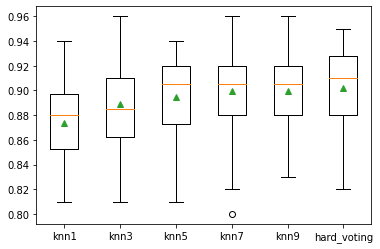

In [20]:
# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, statistics.mean(scores), np.std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

&emsp;&emsp;我们得到的结果如下：    
>knn1 0.873 (0.030)    
>knn3 0.889 (0.038)    
>knn5 0.895 (0.031)    
>knn7 0.899 (0.035)    
>knn9 0.900 (0.033)    
>hard_voting 0.902 (0.034)    

&emsp;&emsp;显然投票的效果略大于任何一个基模型。

&emsp;&emsp;通过箱形图我们可以看到硬投票方法对交叉验证整体预测结果分布带来的提升。

## bagging的思路

&emsp;&emsp;与投票法不同的是，Bagging不仅仅集成模型最后的预测结果，同时采用一定策略来影响基模型训练，保证基模型可以服从一定的假设。在上一章中我们提到，希望各个模型之间具有较大的差异性，而在实际操作中的模型却往往是同质的，因此一个简单的思路是通过不同的采样增加模型的差异性。

## bagging的原理分析

&emsp;&emsp;Bagging的核心在于自助采样(bootstrap)这一概念，即有放回的从数据集中进行采样，也就是说，同样的一个样本可能被多次进行采样。一个自助采样的小例子是我们希望估计全国所有人口年龄的平均值，那么我们可以在全国所有人口中随机抽取不同的集合（这些集合可能存在交集），计算每个集合的平均值，然后将所有平均值的均值作为估计值。

&emsp;&emsp;首先我们随机取出一个样本放入采样集合中，再把这个样本放回初始数据集，重复K次采样，最终我们可以获得一个大小为K的样本集合。同样的方法， 我们可以采样出T个含K个样本的采样集合，然后基于每个采样集合训练出一个基学习器，再将这些基学习器进行结合，这就是Bagging的基本流程。

&emsp;&emsp;对回归问题的预测是通过预测取平均值来进行的。对于分类问题的预测是通过对预测取多数票预测来进行的。Bagging方法之所以有效，是因为每个模型都是在略微不同的训练数据集上拟合完成的，这又使得每个基模型之间存在略微的差异，使每个基模型拥有略微不同的训练能力。

&emsp;&emsp;Bagging同样是一种降低方差的技术，因此它在不剪枝决策树、神经网络等易受样本扰动的学习器上效果更加明显。在实际的使用中，加入列采样的Bagging技术对高维小样本往往有神奇的效果。

## bagging的案例分析(基于sklearn，介绍随机森林的相关理论以及实例)

&emsp;&emsp;Sklearn为我们提供了 [BaggingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html) 与 [BaggingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) 两种Bagging方法的API，我们在这里通过一个完整的例子演示Bagging在分类问题上的具体应用。这里两种方法的默认基模型是树模型。

&emsp;&emsp;这里的树模型一般指决策树，它是一种树形结构，树的每个非叶子节点表示对样本在一个特征上的判断，节点下方的分支代表对样本的划分。决策树的建立过程是一个对数据不断划分的过程，每次划分中，首先要选择用于划分的特征，之后要确定划分的方案（类别/阈值）。我们希望通过划分，决策树的分支节点所包含的样本“纯度”尽可能地高。节点划分过程中所用的指标主要是信息增益和GINI系数。

&emsp;&emsp;信息增益衡量的是划分前后信息不确定性程度的减小。信息不确定程度一般使用信息熵来度量，其计算方式是：
$$
H(Y) = -\sum{p_ilogp_i}
$$
&emsp;&emsp;其中i表示样本的标签，p表示该类样本出现的概率。当我们对样本做出划分之后，计算样本的条件熵：
$$
H(Y|X) = -\sum_{x\in X}p(X=x){H(Y|X=x)}
$$

&emsp;&emsp;其中x表示用于划分的特征的取值。信息增益定义为信息熵与条件熵的差值：
$$
IG = H(Y) - H(Y|X)
$$

&emsp;&emsp;信息增益IG越大，说明使用该特征划分数据所获得的信息量变化越大，子节点的样本“纯度”越高。

&emsp;&emsp;同样的，我们也可以利用Gini指数来衡量数据的不纯度，计算方法如下：
$$
Gini = 1 - \sum{p_i^2}
$$
&emsp;&emsp;当我们对样本做出划分后，计算划分后的Gini指数：
$$
Gini_x = \sum_{x\in X}p(X=x)[1 - \sum{p_i^2}]
$$
&emsp;&emsp;一般来说，我们选择使得划分后Gini指数最小的特征（注意这里是直接根据Gini指数进行判断，而并非其变化量）。

&emsp;&emsp;下方给出了决策树的一个例子，我们要训练一个模型，根据天气、温度和风力等级来判断是否打网球。    
![image-20210411151227186](./DecisionTree.png)

首先我们通过计算信息增益或Gini指数确定了首先根据天气情况对样本进行划分，之后对于每个分支，继续考虑除天气之外的其他特征，直到样本的类别被完全分开，所有特征都已使用，或达到树的最大深度为止。

Bagging的一个典型应用是随机森林。顾名思义，“森林”是由许多“树”bagging组成的。在具体实现上，用于每个决策树训练的样本和构建决策树的特征都是通过随机采样得到的，随机森林的预测结果是多个决策树输出的组合（投票）。随机森林的示意图如下：

![image-20210411161043251](./RandomForest.png)



下面我们使用sklearn来实现基于决策树方法的bagging策略。

&emsp;&emsp;我们创建一个含有1000个样本20维特征的随机分类数据集：

In [21]:
# test classification dataset
from sklearn.datasets import make_classification
# define dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, 
                           n_redundant=5, random_state=5)
# summarize the dataset
print(X.shape, y.shape)

(1000, 20) (1000,)


&emsp;&emsp;我们将使用重复的分层k-fold交叉验证来评估该模型，一共重复3次，每次有10个fold。我们将评估该模型在所有重复交叉验证中性能的平均值和标准差。

In [22]:
# evaluate bagging algorithm for classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import BaggingClassifier
# define dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=5)
# define the model
model = BaggingClassifier()
# evaluate the model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.855 (0.039)


&emsp;&emsp;最终模型的效果是Accuracy: 0.856 标准差0.037